In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import librosa
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
def create_audio_dataframe(dataset_path, file_extension=".wav", max_files_per_class=5000):
    data = []
    
    # Loop through each folder in the dataset directory
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        
        # Ensure it's a directory
        if os.path.isdir(folder_path):
            files_in_class = []
            
            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                if file_name.endswith(file_extension):  # Only add audio files
                    file_path = os.path.join(folder_path, file_name)
                    files_in_class.append(file_path)
                    
                    # Stop if we've already collected 'max_files_per_class' files
                    if len(files_in_class) >= max_files_per_class:
                        break
            
            # Add the file paths and class (folder name) to the data list
            for file_path in files_in_class:
                data.append({"path": file_path, "class": folder_name})
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

In [3]:

dataset_path = r"C:\Users\saik2\Music\Speech Emotion Classification\DATASET\Voice"  # Replace with your actual dataset path
df = create_audio_dataframe(dataset_path)
print(df.head())

                                                path  class
0  C:\Users\saik2\Music\Speech Emotion Classifica...  anger
1  C:\Users\saik2\Music\Speech Emotion Classifica...  anger
2  C:\Users\saik2\Music\Speech Emotion Classifica...  anger
3  C:\Users\saik2\Music\Speech Emotion Classifica...  anger
4  C:\Users\saik2\Music\Speech Emotion Classifica...  anger


In [4]:
# Basic information about the dataset
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1436 non-null   object
 1   class   1436 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB
None


In [5]:
# Checking for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
path     0
class    0
dtype: int64


In [6]:
# Distribution of classes
print("Class Distribution:")
class_counts = df['class'].value_counts()
print(class_counts)

Class Distribution:
class
happy    600
anger    546
sad      290
Name: count, dtype: int64


C:\Users\saik2\AppData\Local\Temp\ipykernel_1848\1592787767.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='class', palette="viridis")


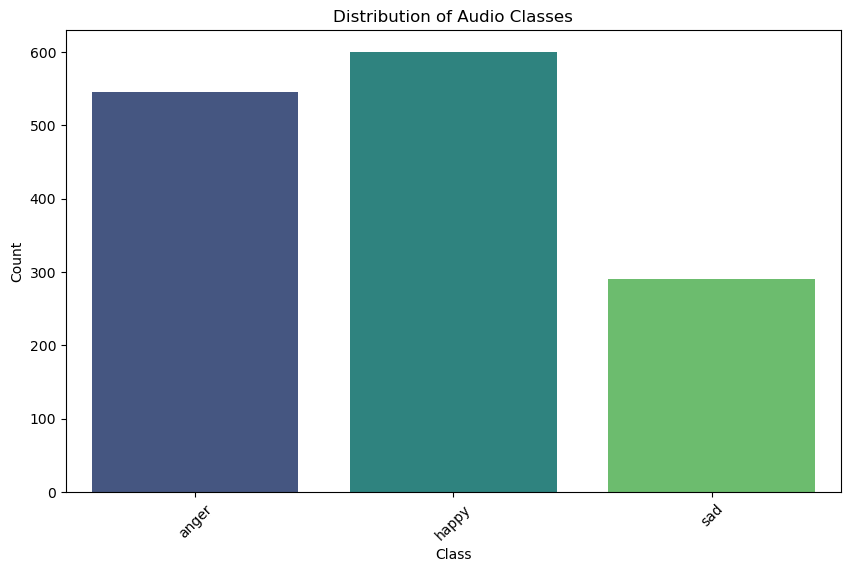

In [7]:
# Plotting the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class', palette="viridis")
plt.title("Distribution of Audio Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Length of file paths and class names (useful for checking for anomalies)
df['path_length'] = df['path'].apply(len)
df['class_length'] = df['class'].apply(len)

In [9]:
# Basic statistics of path and class lengths
print("Path Length Statistics:")
print(df['path_length'].describe())
print("Class Length Statistics:")
print(df['class_length'].describe())

Path Length Statistics:
count    1436.000000
mean       97.924791
std         2.644550
min        90.000000
25%        95.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: path_length, dtype: float64
Class Length Statistics:
count    1436.00000
mean        4.59610
std         0.80319
min         3.00000
25%         5.00000
50%         5.00000
75%         5.00000
max         5.00000
Name: class_length, dtype: float64


In [10]:
# Example of file paths per class
print("Example file paths by class:")
for class_name in df['class'].unique():
    sample_files = df[df['class'] == class_name]['path'].sample(3, random_state=1).tolist()
    print(f"\nClass '{class_name}':")
    print(sample_files)

Example file paths by class:

Class 'anger':
['C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\anger\\03-01-04-01-01-02-18_aug1.wav', 'C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\anger\\03-01-04-01-01-01-19.wav', 'C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\anger\\03-01-04-01-02-01-04.wav']

Class 'happy':
['C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\happy\\03-01-02-01-02-02-18_aug0.wav', 'C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\happy\\03-01-02-01-02-02-09_aug3.wav', 'C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\happy\\03-01-02-02-01-01-06_aug3.wav']

Class 'sad':
['C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\sad\\03-01-03-01-01-02-03_aug1.wav', 'C:\\Users\\saik2\\Music\\Speech Emotion Classification\\DATASET\\Voice\\sad\\03-01-03-01-02-01-06_aug0.wav', 'C:\\Users\\saik2\\Music\\Speech Emotion

In [11]:
# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load the audio file
    # Example feature: Mel-frequency cepstral coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # 40 MFCCs
    return np.mean(mfccs.T, axis=0).tolist()  # Return the mean of the MFCCs

In [12]:
# Create a new DataFrame for features
features_list = []
tqdm.pandas(desc="Processing audio files")  # Initialize tqdm
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    features = extract_features(row['path'])
    features_list.append(features)

100%|██████████████████████████████████████████████████████████████████████████████| 1436/1436 [00:23<00:00, 61.40it/s]


In [13]:
# Create the new DataFrame
feature_df = pd.DataFrame({
    'features': features_list,
    'class': df['class']
})

In [14]:
#feature_df = load_audio_files(df)
print(feature_df.head())

                                            features  class
0  [-715.8726806640625, 74.98530578613281, 2.9195...  anger
1  [-681.3284301757812, 65.79010009765625, -3.123...  anger
2  [-309.9170837402344, 4.334590911865234, 4.9079...  anger
3  [-697.0679321289062, 65.1627197265625, -2.8511...  anger
4  [-708.91943359375, 64.58836364746094, -1.22302...  anger


In [15]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'class' column
feature_df['class_encoded'] = label_encoder.fit_transform(feature_df['class'])

In [17]:
# Save the label encoder to a file
label_encoder_path = 'label_encoder.pkl'  # Specify the path to save the encoder
with open(label_encoder_path, 'wb') as file:
    pickle.dump(label_encoder, file)

In [16]:
# Split the data into training and testing sets
X = feature_df['features'].tolist()  # Extract features (list of lists)
y = feature_df['class_encoded']  # Extract the encoded labels

In [17]:
# Convert y to one-hot encoding using to_categorical
y = to_categorical(y)

In [18]:
# Convert X to a NumPy array if it isn't already
X = np.array(X)  # Ensure that X is a NumPy array

In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
y_train.shape

(1005, 3)

In [21]:
# Define the model
model = Sequential([
    # Dense layers (ANN part)
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    
    # Reshape the output of the Dense layers to be 3D
    Reshape((1, 64)),  # Reshape output to (batch_size, timesteps, features) for LSTM
    
    # Add LSTM layer as the last layer
    LSTM(64, return_sequences=False),  # One LSTM layer
    Dropout(0.3),
    
    # Output layer (softmax for multi-class classification)
    Dense(y_train.shape[1], activation='softmax')  # Corrected: use y_train for output dimension
])

C:\Users\saik2\anaconda3\envs\speech\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,867 (331.51 KB)

 Trainable params: 84,867 (331.51 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [25]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3545 - loss: 1.1600 - val_accuracy: 0.3805 - val_loss: 1.0604 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3933 - loss: 1.0907 - val_accuracy: 0.4176 - val_loss: 1.0585 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4113 - loss: 1.0761 - val_accuracy: 0.5128 - val_loss: 1.0375 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4112 - loss: 1.0794 - val_accuracy: 0.5012 - val_loss: 1.0313 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4396 - loss: 1.0574 - val_accuracy: 0.5499 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4381 - loss: 1.0578 - val_accuracy: 0.4153 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4510 - loss: 1.0230 - val_ac

In [26]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5480 - loss: 0.9030 
Test Loss: 0.9077389240264893
Test Accuracy: 0.5522041916847229


In [27]:
# Evaluate the model on the test data
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5520 - loss: 0.9020 
Train Loss: 0.9079268574714661
Train Accuracy: 0.5522388219833374


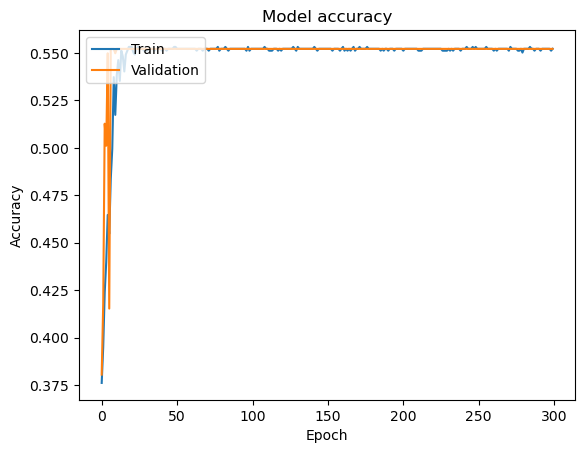

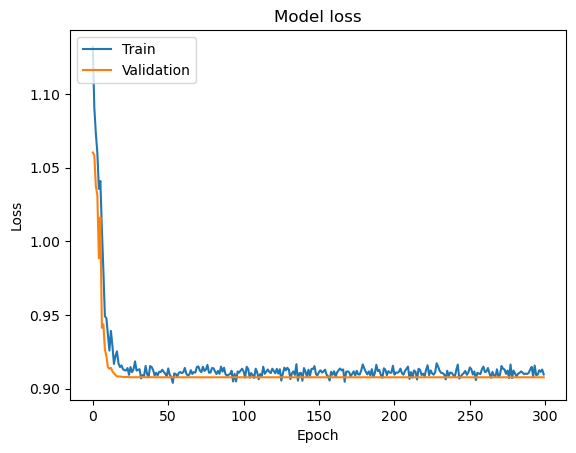

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step 
Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.35      0.52       164
       happy       0.48      1.00      0.65       180
         sad       0.00      0.00      0.00        87

    accuracy                           0.55       431
   macro avg       0.49      0.45      0.39       431
weighted avg       0.58      0.55      0.47       431



C:\Users\saik2\anaconda3\envs\speech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saik2\anaconda3\envs\speech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saik2\anaconda3\envs\speech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


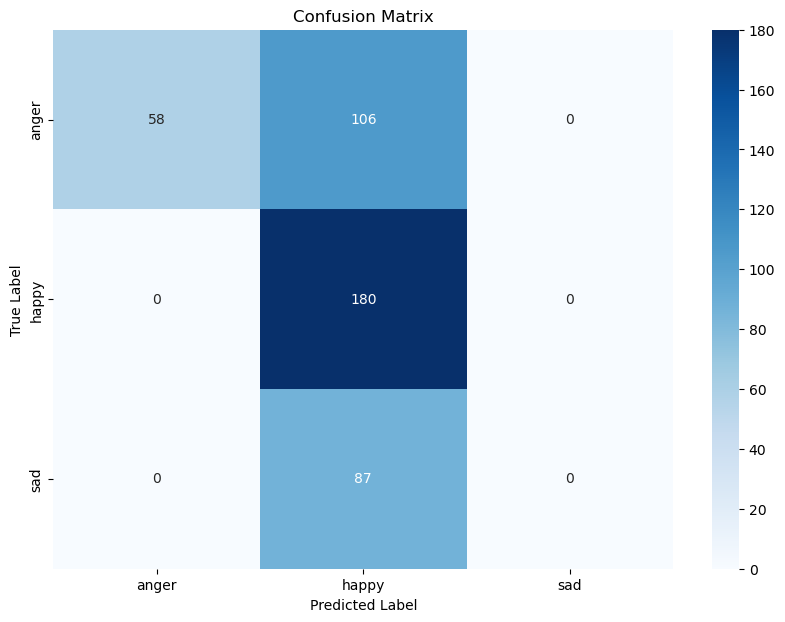

In [29]:
# Predict the class labels on the test data
y_pred = model.predict(X_test)

# Since y_pred is in one-hot encoding, convert it to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to class labels as well (it's currently one-hot encoded)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
model.save('lstm.keras')

In [31]:
# Define the model with only Dense layers and a final CNN layer
model_cnn = Sequential([
    # Dense layers (ANN part)
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    
    # Reshape to make it suitable for the CNN layer (64, 1) becomes (64, 1, 1)
    Reshape((64, 1)),  # Increased sequence length to 64
    
    # Add a CNN layer (1D Convolutional layer)
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Max Pooling to reduce dimensionality
    
    # Flatten the output to feed into the Dense output layer
    Flatten(),
    
    # Output layer (softmax for multi-class classification)
    Dense(y_train.shape[1], activation='softmax')  # Corrected: use y_train for output dimension
])

C:\Users\saik2\anaconda3\envs\speech\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Print the model summary
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 64, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,051 (226.76 KB)

 Trainable params: 58,051 (226.76 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
history = model_cnn.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3773 - loss: 2.7388 - val_accuracy: 0.3434 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3913 - loss: 1.2216 - val_accuracy: 0.5383 - val_loss: 1.0582 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4565 - loss: 1.0726 - val_accuracy: 0.5522 - val_loss: 1.0077 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4874 - loss: 1.0413 - val_accuracy: 0.3805 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5193 - loss: 0.9654 - val_accuracy: 0.5522 - val_loss: 0.9355 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4944 - loss: 0.9828 - val_accuracy: 0.3805 - val_loss: 0.9626 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4672 - loss: 0.9802 - 

In [35]:
# Evaluate the model on the test data
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6808 - loss: 0.6814 
Test Loss: 0.6642839908599854
Test Accuracy: 0.6867749691009521


In [36]:
# Evaluate the model on the test data
train_loss, train_acc = model_cnn.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8260 - loss: 0.3954 
Train Loss: 0.4029076099395752
Train Accuracy: 0.8308457732200623


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Classification Report:
              precision    recall  f1-score   support

       anger       0.65      0.59      0.62       164
       happy       0.68      0.74      0.71       180
         sad       0.76      0.76      0.76        87

    accuracy                           0.69       431
   macro avg       0.70      0.70      0.70       431
weighted avg       0.69      0.69      0.69       431



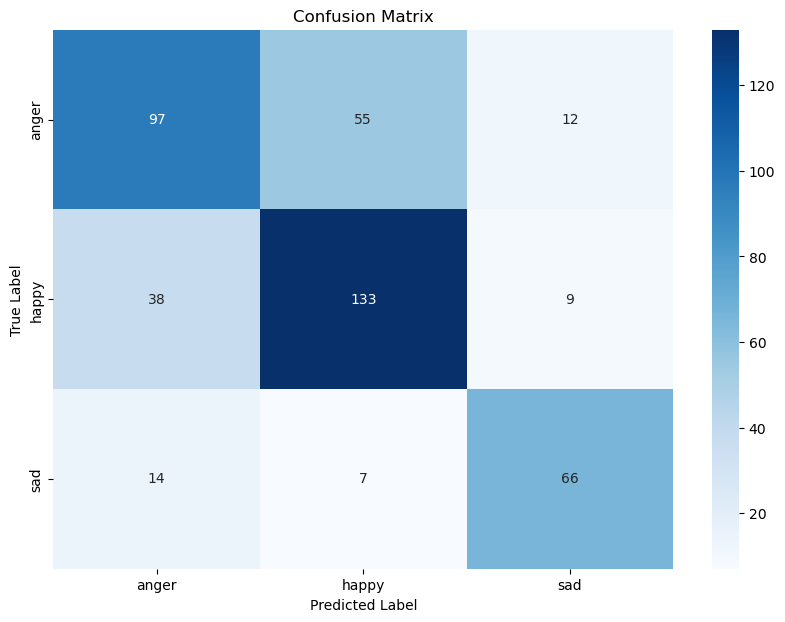

In [37]:
# Predict the class labels on the test data
y_pred = model_cnn.predict(X_test)

# Since y_pred is in one-hot encoding, convert it to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to class labels as well (it's currently one-hot encoded)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

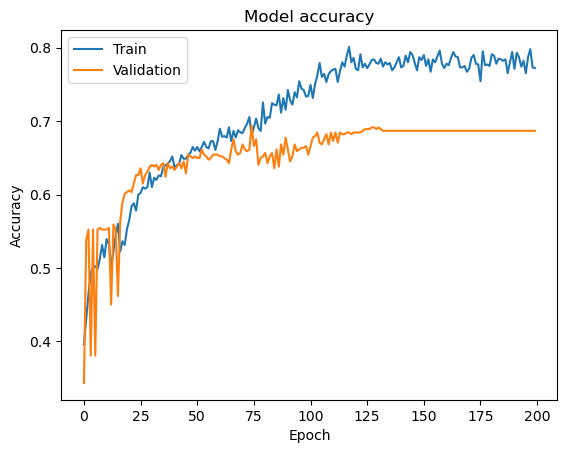

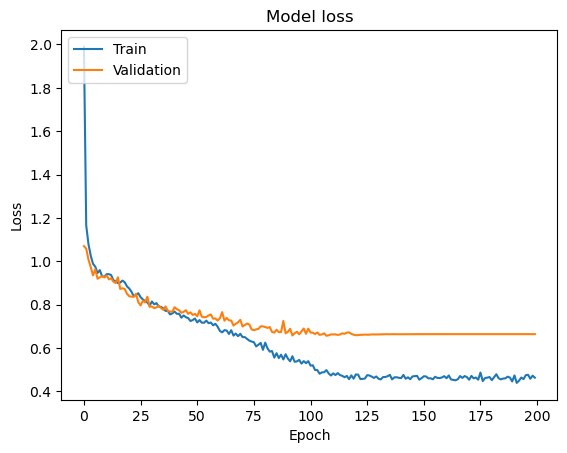

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [132]:
model_cnn.save('cnn_model.keras')